# Performing analysis with GeoPandas
http://geopandas.org/

This notebook wades gently into the world of GeoPandas and also serves as a review of several Pandas operations. Specifically we examine the following:
* Reading & writing shapefiles into a GeoPandas dataFrame
* Exploring the GeoPandas dataFrame
 * Exposing the number of features 
 * Revealing the data types of each column 
 * Exploring the `geometry` data type
* Quick view of plotting in GeoPandas
* Quick view of geoprocessing in GeoPandas

### Install the package and enable inline plots

In [1]:
#import the package
import geopandas as gpd

#enable plots to appear in the notebook
%matplotlib inline

### ►_Fix required_◄
You need to run this code block to fix an issue with the `pyproj` module used by GeoPandas. Be sure the `envName` variable reflects the enviroment you are using. 

For more on the issue see: 
https://github.com/geopandas/geopandas/issues/830

In [2]:
#Set the the Conda environment you are using
envName = 'my_env'

#Fix the issue with pyproj
import os
localappPth = os.environ.get('localappdata', '')
os.environ["PROJ_LIB"] = "{}\\ESRI\\conda\\envs\\{}\\Library\\share".format(localappPth,envName)

### Read a shapefile into a _GeoDataframe_
GeoPandas can read shapefiles directly. Behind the scenes, this operation is using the `GDAL` package which contains the binaries capable of understanding geospatial data, the `fiona` package, which allows Python to interact nicely with `GDAL` libraries, and the `shapely` package which has functions for operating with feature classes in a Pythonic way. GeoPandas coordinate reference systems can use the "European Petroleum Survey Group" (EPSG) codes as shorthand for various standard systems. 

Complete documentation on the GeoDataframe is here: http://geopandas.org/data_structures.html#geodataframe

In [3]:
#read in the HUC12.shp feature class
gdf = gpd.read_file('./Data/HUC12.shp')

In [4]:
#How many features in the dataset?
len(gdf)

210

In [6]:
#What coordinate reference system is used? Check http://epsg.io for what this code is
gdf.crs

{'init': 'epsg:4269'}

→ If the crs returns an 'epsg' code you can generate a URL to look it up...

In [7]:
#Get the epsg code from the crs
epsg = gdf.crs['init'].split(':')[1]
#Generate and print the URL, which you can click on...
print("http://epsg.io/{}".format(epsg))

http://epsg.io/4269


In [8]:
#show the geometry types in this geodataframe
gdf.type.unique()

array(['Polygon'], dtype=object)

In [9]:
#examine the attributes for the first feature
gdf.iloc[0]

OBJECTID_2                                                80221
OBJECTID                                                  58735
HUC_8                                                  03040103
HUC_10                                               0304010305
HUC_12                                             030401030503
ACRES                                                     15414
NCONTRB_A                                                     0
HU_10_GNIS                                                 None
HU_12_GNIS                                                 None
HU_10_DS                                             0304010306
HU_10_NAME                                 Lower Uwharrie River
HU_10_MOD                                                    NM
HU_10_TYPE                                                    S
HU_12_DS                                           030401030504
HU_12_NAME                                         Barnes Creek
HU_12_MOD                               

### Projections in GeoPandas
We can reproject our data in GeoPandas. Here we'll reproject our NAD83 data to UTM Zone 17, which has an EPSG code of `26917`. 

In [10]:
gdfUTM  = gdf.to_crs({'init':'epsg:26917'})

### Exploring the `geometry` objects in a GeoPandas dataframe
The key to Geopandas ability to work with geospatial data is by adding a new data type to the standard Pandas dataFrame: this is stored in the `geometry` field. Let's explore this field. 

Complete documentation on the geometry object is here: http://geopandas.org/geometric_manipulations.html

In [11]:
#show the first 5 values in the geometry field: this is actually a GeoSeries...
gdfUTM['geometry'][0:5]

0    POLYGON ((600728.0588428936 3926836.796062584,...
1    POLYGON ((584522.8731034887 3935577.997112833,...
2    POLYGON ((556966.8088246823 3976400.421130748,...
3    POLYGON ((549670.497283495 3977272.417634605, ...
4    POLYGON ((561401.9756115625 3859627.842079137,...
Name: geometry, dtype: object

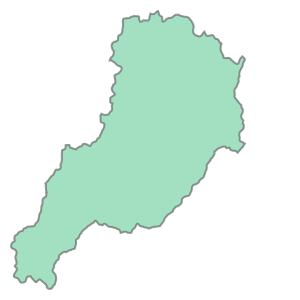

In [12]:
#show just the first value - it appears as a shape
gdfUTM['geometry'][0]

Now let's save that one geometry object, a polygon in this case to variable and examine what GeoPandas allows us to do with it. 

In [13]:
#Extract one feature geometry to a variable; what is its datatype?
thePoly = gdfUTM['geometry'][0]
type(thePoly)

shapely.geometry.polygon.Polygon

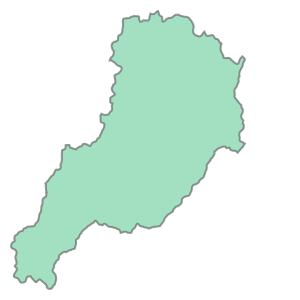

In [14]:
#Show thePoly
thePoly

In [19]:
#Show the area and perimeter length
theArea = thePoly.area
thePerim = thePoly.length
print ("Area (m2):",int(theArea))
print ("Permeter (m):",int(thePerim))

Area (m2): 62345548
Permeter (m): 46280


In [16]:
#Convert the polygon's boundary to a linestring (i.e. a line feature)
theBoundary = thePoly.boundary
type(theBoundary)

shapely.geometry.linestring.LineString

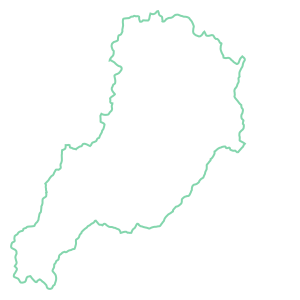

In [17]:
#Show the 
theBoundary

In [20]:
#Create the centroid of the feature
theCentroid = thePoly.centroid
type(theCentroid)

shapely.geometry.point.Point

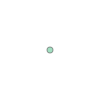

In [21]:
theCentroid

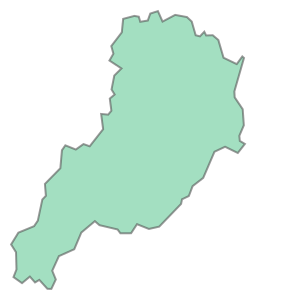

In [25]:
theCentroid.buffer(100)
thePoly.convex_hull # create simplified hull outline
thePoly.simplify(100) # no vertices closer than 100m

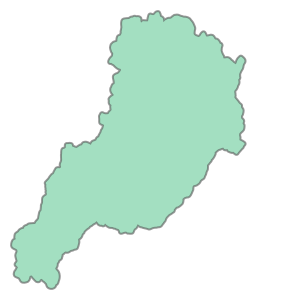

In [22]:
#Buffer the polygon 100m
thePoly.buffer(100)

AttributeError: 'Point' object has no attribute 'plot'

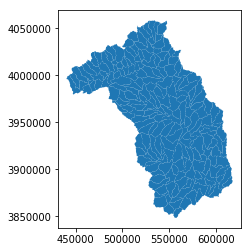

In [35]:
gdfUTM.plot()
gdfUTM.unary_union.centroid # dissolves into single object, calculates centroid

→ Other feature transformations to try: `convex_hull`, `envelope`, `simplify`...

#### Distance analyses
We can also compute distances fairly easily with GeoPandas objects. Here we'll compute the distance of each feature to the center point of all features.

In [26]:
#Compute the center of all features combined
theCenter = gdfUTM.unary_union.centroid #distance(durhamPtDD)

In [27]:
#Compute the distance of each feature to this center point & show the mean
theDistances = gdfUTM.distance(theCenter)/1000
theDistances.mean()

50.90963488266861

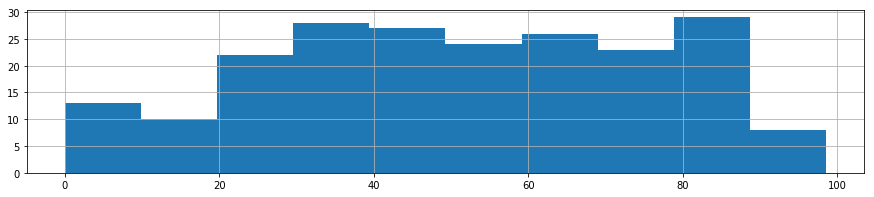

In [30]:
#Plot a histogram of values
theDistances.hist(figsize=(15,3));

### A more complex analyis
Here we will buffer the centroid of a feature and then intersect that with the feature. 

* We begin by selecting a feature. We'll pick on the Elk Creek HUC...

In [36]:
#Select a feature by an attribute
hucMask = gdfUTM['HU_12_NAME'] == 'Elk Creek'
gdfHUC = gdfUTM[hucMask]
type(gdfHUC)

geopandas.geodataframe.GeoDataFrame

In [37]:
gdfHUC

,OBJECTID_2,OBJECTID,HUC_8,HUC_10,HUC_12,ACRES,NCONTRB_A,HU_10_GNIS,HU_12_GNIS,HU_10_DS,...,STATES,GlobalID,SHAPE_Leng,GAZ_ID,WBD_Date,VPUID,Shape_Le_1,Shape_STAr,Shape_STLe,geometry
46,81447,162359,03040101,0304010101,030401010104,32340.0,0.0,None,None,0304010102,...,NC,{4A47B982-D073-418B-800E-B82D62CBCB51},0.779781,-397912,2012-02-01,03N,0.779777,0.013107,0.779777,"POLYGON ((452136.6132589387 4009763.407632078,..."


►This approach is slightly different than in the above example (`thePoly = gdfUTM['geometry'][0]`) which returned a _Shapely geometry_ object from the geodataframe; here our query returns a _GeoSeries_ object. However, other than plotting, the behavior is mostly the same.

In [38]:
#Get the shape of the feature
feature_geometry = gdfHUC['geometry'] #->returns a GeoSeries, not a shapely geometry
type(feature_geometry)

geopandas.geoseries.GeoSeries

In [39]:
#Copy the dfHUC dataframe and then we'll modify geometries
gdfHUC_copy = gdfHUC.copy(deep=True) # deep=True means that you actually want a completely new copy, not just a new shortcut

In [40]:
#Update geometry to the centroid of each feature buffered 5000m
gdfHUC_copy['geometry'] = gdfHUC_copy['geometry'].centroid.buffer(5000)

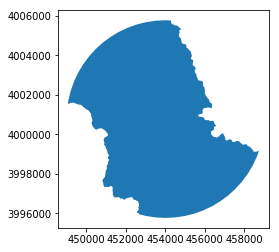

In [41]:
#Buffer the centroid
theBuffer = theCentroid.buffer(100)
#Intersect the buffer and the original shape
theClip = gpd.overlay(gdfHUC_copy,gdfHUC,how='intersection')
#Show the Clip
theClip.plot()

## Geospatial capabilities of the GeoPandas dataFrame object

In [42]:
#Dissolving
dfHUC8 = gdf.dissolve(by='HUC_8',aggfunc='sum')
dfHUC8.dtypes

geometry       object
OBJECTID_2      int64
OBJECTID        int64
ACRES         float64
NCONTRB_A     float64
SHAPE_Leng    float64
GAZ_ID          int64
Shape_Le_1    float64
Shape_STAr    float64
Shape_STLe    float64
dtype: object

C:\Users\sb496\AppData\Local\ESRI\conda\envs\my_env\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


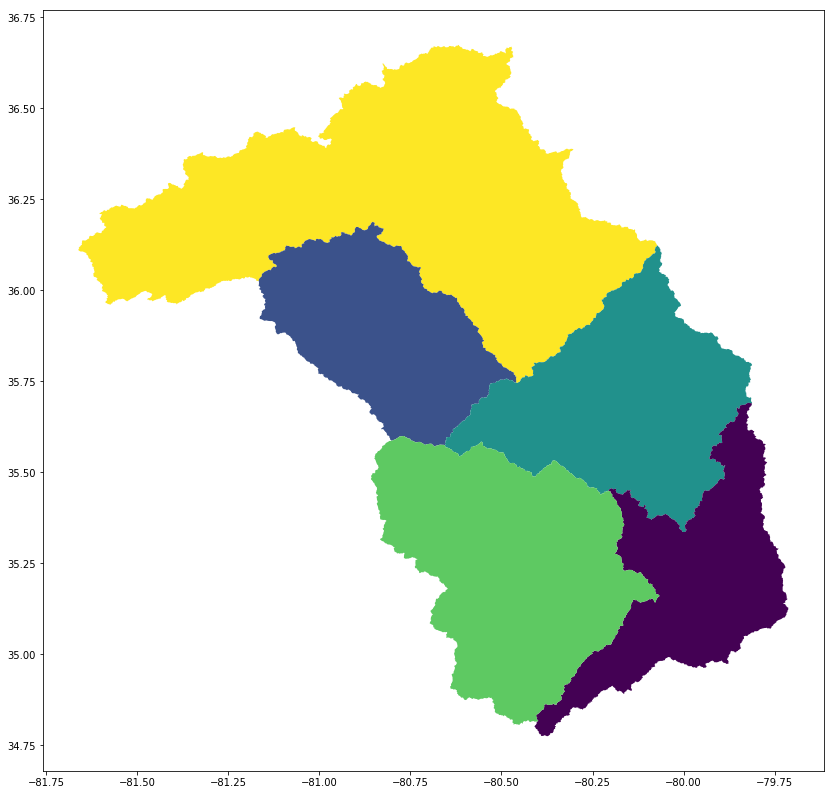

In [43]:
dfHUC8.plot(column='ACRES',
            scheme='quantiles',        
            figsize=(14,18));

## Recap
In this super quick introduction to GeoPandas, we saw that the GeoDataFrame is easy to construct from a shapefile, and once constructed gives us access to the analytic capability of Pandas dataframes (e.g. selecting, summarizing, etc.) as well as plotting and spatial analytic capability. 

I'm hopeful that at the end of this short introduction you're eager to read up on the documentation and learn more what GeoPandas can do. 